Artistic Style Transfer refers to recomposing images(content images) with the style of some artisttic work(style image)  where the resulting image has content of the content image and style of the style image.

To perform artistic style transfer we require a model that can learn the features of both content and style images and then can combine them into a new image. Convolutional Neural Networks comes in handy in doing such a job as they are all about representations of images fed to them so they can be used to learn the features of the images and they do so with the help of two layers - Convolutional Layer and Pooling Layer. The lower layers in a Convolutional Neural Network or CNN learns simple features of the image such as edges and as the layers get deeper more complex features such as contours and object positions are learned. As these layers in a CNN covers the whole image they are able to learn these features irresepective of the position of the feature and their orientation which makes them better than Deep Neural Networks for the same task.

There have been many CNN architectures been developed over many years and trained on various datasets from Imagenet(a dataset consisting of millions of images). We are going to follow the paper by [Gatys et.al](https://https://arxiv.org/abs/1508.06576) that proposed the artistic style transfer algorithm using a CNN architecture called VGGNet.It was introduced as one of the contenders in 2014’s ImageNet Challenge and secured the first and the second places in the localisation and classification tracks respectively.This architecture can have layers varying from 11-19 and can be used for a range of Computer Vision tasks (as shown in the image below).


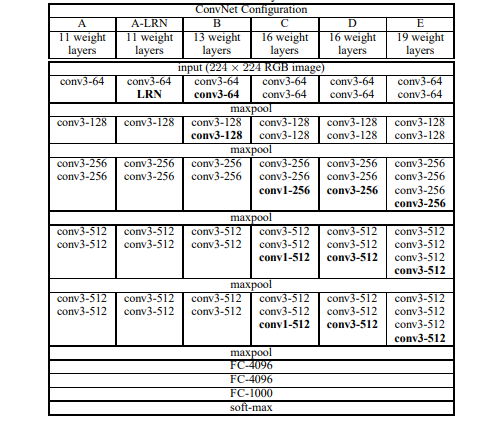

We are going to use VGG19 as proposed in the paper.The paper proposes the style transfer problem as an optimization problem. It mentions that there are three losses that we need to minimize, First is the content loss which is defined as how much the combination image and the content image differs from each other in terms of content, Second is the style loss which is defined as how much the combination image differs from style image in terms of style and Third is the total variation loss which just tries to maintain the spatial coherence in the combined image. All we need to do is to minimize these three losses combined.

As VGGNet has learned to encode semantic and perceptual information about images using feature representations output by various layers of it,these losses are calculated with the help of the the feature representations given by different layers of the VGGNet.

Now we can start coding and explain the further steps as the code progresses.

Import Necessary Libraries.

In [27]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg19 import VGG19

from scipy.optimize import fmin_l_bfgs_b


Tensorflow is used as Backend.

# Load and preprocess the Content and Style images.

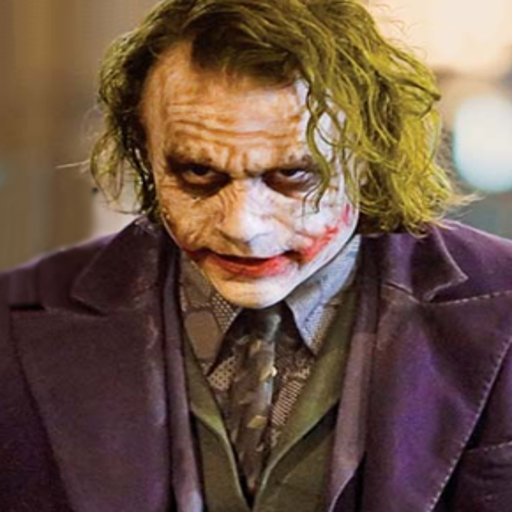

In [28]:
height = 512
width = 512

content_image_path = '/content/HeathJoker.png'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

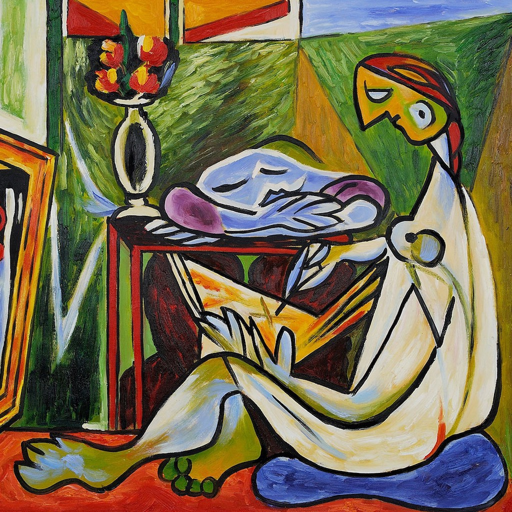

In [29]:
style_image_path = "/content/picasso.jpg"
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3) dimensions(height is the height of image,width is the width of the image ,3 is for colordepth if RGB scheme is used and 1 if greysacle is used) so that we can later concatenate the representations of these two images into a common data structure.

In [30]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to tweak this input data to match what was done in [the original VGGNet paper](https://https://arxiv.org/abs/1409.1556).

For this, we need to perform two transformations:


1. Subtract the mean RGB value (computed previously on the ImageNet training set and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from RGB to BGR (the ordering used in the paper).


In [31]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

We also introduce a placeholder variable to store the combination image that retains the content of the content image along with the style of the style image.

In [32]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [33]:
input_tensor = backend.concatenate([content_image,style_image,combination_image], axis=0)

# Loading the model.

We load the pre-trained VGG19 model without including the fully connected layers (include_top=False) as we are only concerned with the feature representations of the convolution layers.

In [34]:
model = VGG19(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

We look at the different layers in VGG19.

In [35]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_1': <tf.Tensor 'concat:0' shape=(3, 512, 512, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <t

# Defining Losses.

The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following are chosen to match the order of the ratio of content_weight and style_weight as in the paper.

In [36]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [37]:
loss = backend.variable(0.)

# Defining Content Loss.

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [46]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block4_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss =loss+ content_weight * content_loss(content_image_features,
                                      combination_features)

# Defining Style Loss.

For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together.The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [47]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [48]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss =loss+ (style_weight / len(feature_layers)) * sl

# Defining Total Variation Loss.

Total variation loss acts as a regularization,tweaking the total_variation_weight can change the level of noise in the combined image.

In [49]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss =loss+ total_variation_weight * total_variation_loss(combination_image)

In [50]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

# Define gradients.

In [51]:
grads = backend.gradients(loss, combination_image)

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads.

In [52]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve the optimization problem. This combination image begins as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to improve upon it with each iteration.





In [ ]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 100

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

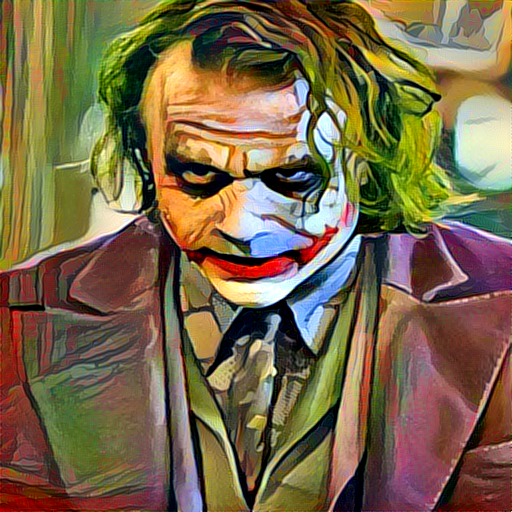

In [54]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)